**Chapter 7 – Ensemble Learning and Random Forests**

Often each model that you estimate grasps some feature of the data, while missing the other. The aggregation of the predictions may result in a better prediction than even the best model by itself. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method. <br>
If you estimate a group of decision trees to make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today. Most of the winners of ML competitions use some kinds of Ensemble learning often involving hundreds of very different models.

If you start with Logistic, SVM, Random Forest and K-Nearest Neighbors classifier. The simples way to aggregate classifiers by the majority voting: this is called _hard voting_. Even an average of weak diverse classifiers can produce better prediction that a single "optimal" classifier. 

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Voting classifiers

Suppose you are have a biased coin with the probability of heads of 51%. On average you obtain the number of heads equal to $N*p_h$, where $N$ is the number of tosses and $p_h$ is the probability of heads. By the law of large numbers the more tosses you make the more likely you observe that there is a different number of heads and tails produced by a biased coin. Binomial distribution tells us the probability of $k$ successes in a $n$ trials with PDF: ${n \choose x} p^k (1-p)^{n-k}$. Using CDF we can calculate probability of observing less than 50% of successes. 
$$P(X \geq 0.5) = 1 - (X < 0.5) = 1 - \sum^{k}_{i=0} {n \choose x} p^k (1-p)^{n-k}$$
where $k = \frac{n}{2} - 1$. This probability of more heads and tails is 0.51 for 1 toss, 0.75 for 1,000 tosses, and 0.97 for 10,000 tosses. 

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

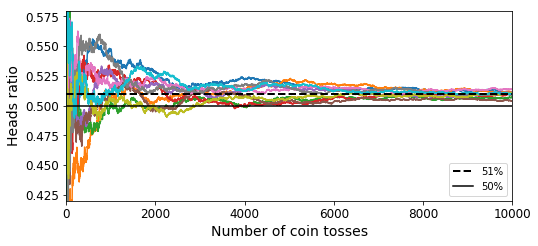

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

Using the same logic if you build 1,000 classifiers that are 51% correct and you use the majority voting class you will get 75% accuracy. However, this is only true if all classifiers are perfectly independent, making uncorrelated errors,
which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy. Diversity of classifiers is the key to success of ensemble learning. <br>


In [4]:
# Let's start with a data of 500 points from the moon function
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We start with simple voting classifier that trains Logistic, Random Forest and SVM classifiers.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)
# voting classifier has syntaxis akin to pipeline
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
# hard voting: each classifier has one vote. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
# Fit all three classifiers in ensemble learning
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

Let's compare the accuracy of three individual classifiers and the ensemble learning. The latter has the highest accuracy.  

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In the example above we use hard-voting: if the majority of classifiers predict a particular class, this class is predicted by the ensemble. A more powerful technique is the soft-voting, where instead of class, each classifier predicts are probability. This gives more weight to the classifiers that are more confident in their predictions. <br>
All you need to do is replace voting="hard" with voting="soft" and **ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).**

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
# set probability to True
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    # soft voting
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Using hard voting ensemble learning accuracy was 0.896, with soft voting it is 0.912. 

# Bagging ensembles

Another approach to ensemble learning is to training the classifiers on different data. We will sample some of the training data for each classifier. **If the sampling is done with replacement it is called _bagging_ if without replacement it is called _pasting_. <br>**

Once we trained all classifiers we aggregate predictions using statistical mode (most frequent prediction like hard voting. **Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.** Generally this results in a similar bias, but lower variance that a single predictor trained on a original training dataset. We can train out data on parallel CPU cores or servers. Bagging and pasting scale very well. <br>

In SkLearn we will use BaggingRegressor. We will train 500 decision Tree classifiers with 100 instances in each. The instances will be randomly sampled with replacement. If you want _pasting_ set (bootstrap=False).**The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores). <br>**

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test) 
#这里的 max_samples 含义和 DecisionTree中对每个Leaf上样本数的限制不一样，这是对bagging classifier的限制

Accuracy of bagging classifier is 90.4% and the accuracy of an individual tree is 85.6%

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Let's plot decision boundaries.

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


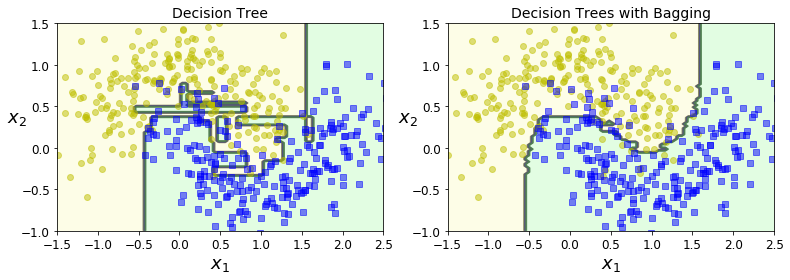

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

The ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular). <br>

Bootstrapping (pasting) introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, **but this also means that predictors end up being less correlated so the ensemble’s variance is reduced**. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best. <br>

In [15]:
pas_clf = BaggingClassifier(
    # We can only estimate 5 estimators withour replacement.
    DecisionTreeClassifier(random_state=42), n_estimators=5,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=42)
pas_clf.fit(X_train, y_train)
y_pred = pas_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.88


In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Saving figure decision_tree_without_and_with_pasting_plot


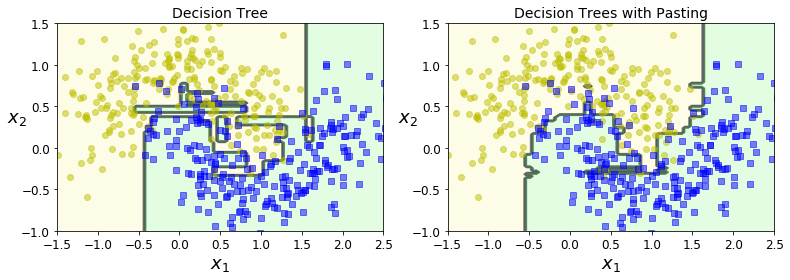

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(pas_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
save_fig("decision_tree_without_and_with_pasting_plot")
plt.show()

Pasting classifier seems much weaker in this example because we only have 500 observations. So we can only draw 5 samples without replacement. A better comparison is with Bagging Classifier that would use only 5 trees. 

In [18]:
bag5_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=5,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag5_clf.fit(X_train, y_train)
y_pred = bag5_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


Saving figure decision_tree_without_and_with_pasting_plot


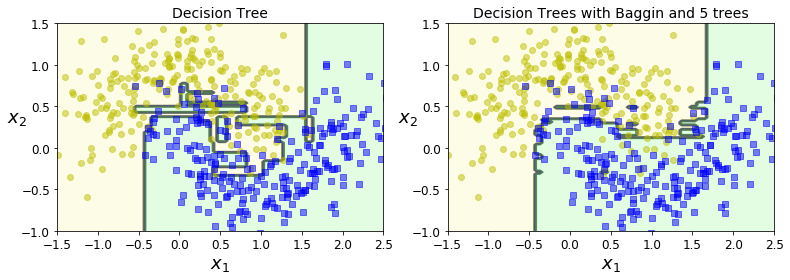

In [19]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag5_clf, X, y)
plt.title("Decision Trees with Baggin and 5 trees", fontsize=14)
save_fig("decision_tree_without_and_with_pasting_plot")
plt.show()

The accuracy is much better using bootrap. The variance probably higher.

* When dealing with high-dimensional inputs, such as images. You may try both sampling of features using max_features and bootstrap_features, this is called Random Spaces. Each predictor will be trained on a random subset of the input features. (bootstrap=False and max_samples=1.0)
* If you have both large number of features and instance, you can sample both: (i.e., bootstrap_features=True and/or max_fea tures smaller than 1.0). This is called Random Patches. 
* **Sampling features results in even more predictor diversity**, trading a bit more bias for a lower variance.

## Out-of-Bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples $m$ training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor assuming we sample the data equal to the number of instances. <br>

The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors. We can average predictions for each estimator using oob instances, without separate validation set or cross-validaion.<br>

To do that we set:  oob_score=True.

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

Even though validation produced slightly lower accuracy, the overall out-of-sample fit maybe better because of superior validation.

In [21]:
# We can extract estimated probabilities from the oob data. 
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [22]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests

Random Forest is the ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building Bagging classifier by hand, you can use RandomForestClassifier, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks). The BaggingClassifier class remains useful if you want a bag of something other than Decision Trees. <br>

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes). <br>

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself. <br>

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. 

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [24]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # Similar predictions predictions

0.976

# Feature Importance
if you look at a single Decision Tree, important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to
the leaves (or not at all). We can estimate of a feature’s importance by computing the average depth at which it appears across all trees in the forest. <br>


Scikit-Learn computes this automatically for every feature after training. You can access the result using the feature_importances_ variable. For example, the following code trains a RandomForestClassifier on the iris dataset  and outputs each feature’s importance. <br>

The most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):

In [27]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [28]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

Feature importance is a key to datasets when you have a lot of features, such as in graphics, when you need to compare the pixels that are the most important for identification. Random Forests are very handy in this task. Let's go back to our digit identification data. 

In [29]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [30]:
# Estimate unrestricted random forest classifier.
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
# Reshape image vector into matrix
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


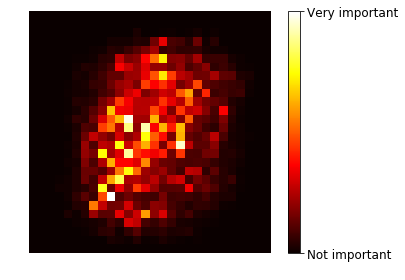

In [32]:
# Plot feature importance
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting 
Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its predecessor.

# AdaBoost

Adaptive Boosting (AdaBoost) focuses on the training instances that the predecessor under-fitted. After each classifier we increase the weight of misclassified training instances. (picture of changing of importance of instances). AdaBoost adds predictors to the ensemble,gradually making it better. <br>

Let's try it on training data. 




In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

SAMME.R uses the probability estimates to update the additive model, while SAMME uses the classifications only. As the example illustrates, the SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.

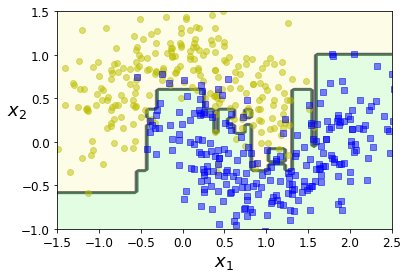

In [34]:
plot_decision_boundary(ada_clf, X, y)

A drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor
can only be trained after the previous predictor has been trained and evaluated. **As a result, it does not scale as well as bagging or pasting. <br>** 规模效应不明显

Initially each instance has a weight $\frac{1}{m}$. After the first classifier is trained we compute the weighted error rate:
$$ r_j = \frac{\sum^m_{\substack{{i=1} \\ {\hat{y}^{(i)}_j \neq y^{(i)}}}}w^{(i)}} {\sum^m_{i=1} w^{(i)}}$$

对当次估计整体而言

where $y^{(i)}_j$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance. <br>

Each predictor is assigned a weight $\alpha_j$, which is computed using equation below, where $\eta$ is the learning
rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing),
then its weight will be negative.
$$\alpha_j = \eta \log\bigg(\frac{1-r_j}{r_j}\bigg)$$
After each estimation we update weights of each observation: 
$$w^{(i)} = \begin{cases} w^{(i)} & \quad if \quad \hat{y}^{(i)}_j = y^{(i)} \\
 w^{(i)}\exp(\alpha_j) & \quad if \quad \hat{y}^{(i)}_j \neq y^{(i)} \end{cases}$$
This updating increases the weight of the incorrectly predicted instance. The increase in weight is a function of the reliabilitiy of the classifier. **If an accurate (high $\alpha_j$) classifier  misclassifies an instance, the weight of this instance increases more than if it missclassified by the inaccurate (low $\alpha_j$) classifier. The all weights are normalized, i.e., divided by $\sum^m_{i=1} w^{(i)}$).** <br>
This process is repeated until are run out of classifiers or we reached a perfect classifier. To make predictions the AdaBoost calculates a weighted average of predictions from all classifiers using $\alpha_j$ as a weight.<br>

Scikit-Learn uses a multiclass version of AdaBoost called SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities, Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better. <br>


Let's try to see this training using SVM classifier just updating sample weights. 

Saving figure boosting_plot


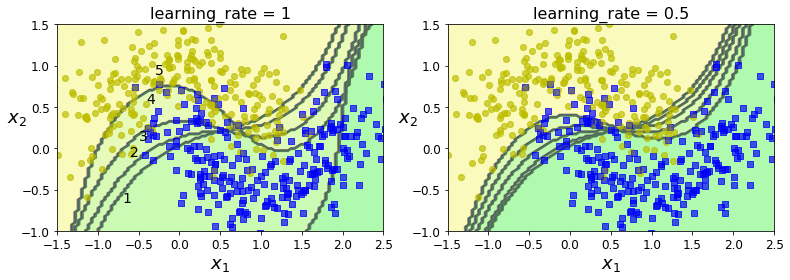

In [35]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)): #进入的是依次顺序的数据 subplot进入121/122
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

Lerning rate 1, may be too fast.

# Gradient Boosting

Another Boosting algorithm is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. **However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual**
errors made by the previous predictor. Let's try it on Tree Regression: $X = u - 0.5$, $y=3X^2 + 0.05*u$.

In [36]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Set Decision Tree regression with maximum depth of 2

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [38]:
# Residuals: y - hat(y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [39]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [40]:
X_new = np.array([[0.8]])

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [41]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [42]:
y_pred

array([0.75026781])

Next we plot the predictions of these three trees in the left column, and the ensemble’s predictions in the right column.

* In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions.
* In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees.
* In the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

Saving figure gradient_boosting_plot


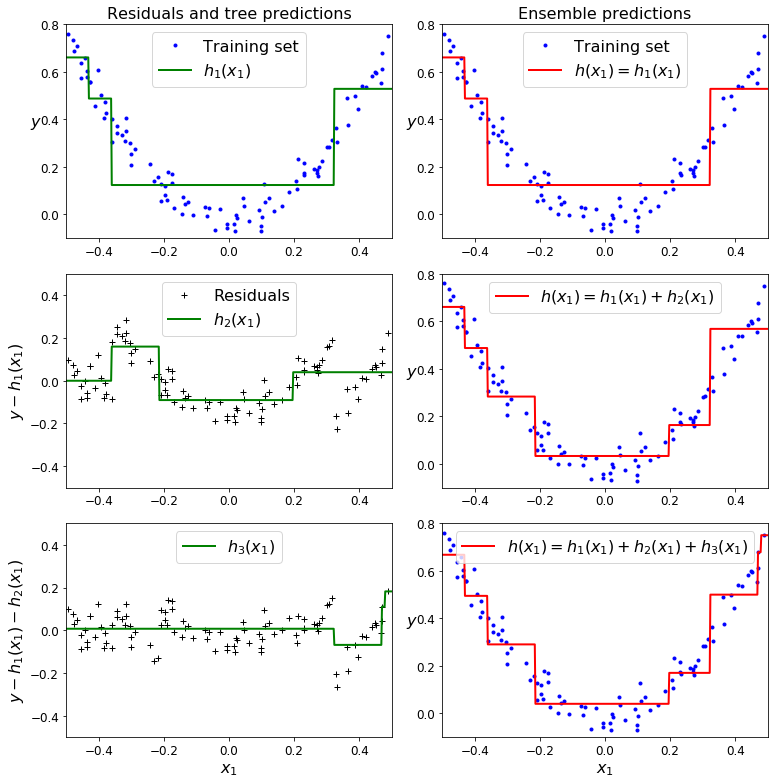

In [43]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRegressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators). 

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [1]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=5, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

NameError: name 'GradientBoostingRegressor' is not defined

**The learning_rate hyperparameter scales the contribution of each tree.** If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage. 

Saving figure gbrt_learning_rate_plot


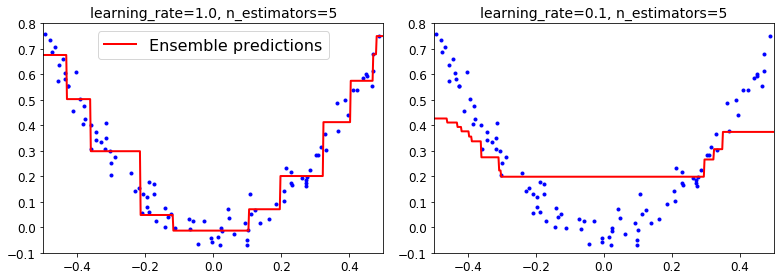

In [46]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

Above we show two GBRT ensembles trained with a low learning rate: the one on the left have enough trees to fit the training set, while the one on the right has too few trees and under-fits the training set. With more (50) trees the performance of slow-learning tree is optimal, while fast-learning is over-fittig.

Saving figure gbrt_learning_rate_plot


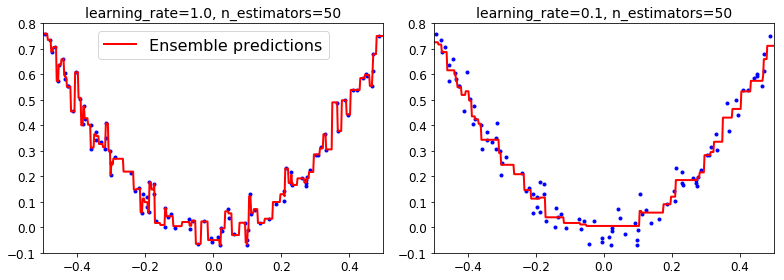

In [47]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training
(with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
# 120 trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
# Calculate errors: staged.predict has a matrix of predictions for adding estimators from 1 to 120.
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
#best number of estimators produces the smallest error.
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [49]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


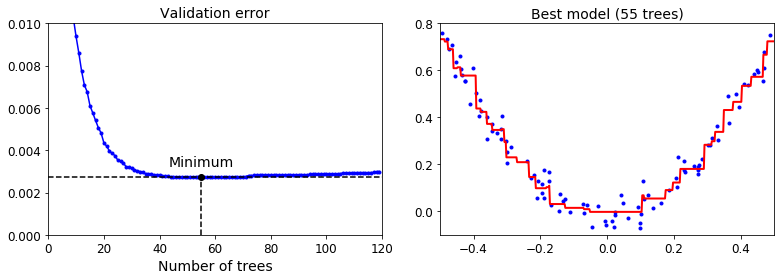

In [50]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

There are few ways to speed thing up:
* When you move from estimating $n$ trees to estimating $n+1$ trees, we can keep the trees we already estimated and just add a one tree by setting warm_start=True allowing incremental training. 
* You can stop learning if the validation error does not improve. The following code stops training when the validation error does not improve for five iterations in a row:

In [51]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
# Start with large error
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    # Set the number of estimators
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    # calculate validation error
    val_error = mean_squared_error(y_val, y_pred)
    # if errors are decreasing nothing happens
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        #if they are increasing start counting, if five steps in a row increase errors then stop
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

We know that the smallest validation error is achieved with 55 trees. Out algorithm stopped at $56 + 5 = 61$ trees:

In [52]:
print(gbrt.n_estimators)

61


In [53]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


The GradientBoostingRegressor class supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instances,
selected randomly. This trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called Stochastic Gradient Boosting.

## Using XGBoost

Use for fast parallel boosting. Probably will not cover in class.

In [54]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

Error: the xgboost library is not installed.


In [55]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

In [56]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

In [57]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

31.1 ns ± 0.472 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [58]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

9.96 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

In [59]:
from sklearn.datasets import fetch_mldata

In [60]:
mnist = fetch_mldata('MNIST original')

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [63]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [64]:
random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [65]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr',

In [66]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9467, 0.9512, 0.8327, 0.9479]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [67]:
from sklearn.ensemble import VotingClassifier

In [68]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [69]:
voting_clf = VotingClassifier(named_estimators)

In [70]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [71]:
voting_clf.score(X_val, y_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9623

In [72]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9467, 0.9512, 0.8327, 0.9479]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [73]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

This updated the list of estimators:

In [74]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       

In [75]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       

However, it did not update the list of _trained_ estimators:

In [76]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [77]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [78]:
voting_clf.score(X_val, y_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9634

Much better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [79]:
voting_clf.voting = "soft"

In [80]:
voting_clf.score(X_val, y_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9663

That's a significant improvement, and it's much better than each of the individual classifiers.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [81]:
voting_clf.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9643

In [82]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9434, 0.9444, 0.9474]

The voting classifier reduced the error rate from about 4.9% for our best model (the `MLPClassifier`) to just 3.5%. That's about 28% less errors, not bad!

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [83]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [84]:
X_val_predictions

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [85]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [86]:
rnd_forest_blender.oob_score_

0.9614

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_ # 将预测对的自变量标记汇集起来进行training

In [87]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [88]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(y_test, y_pred)

0.9554

This stacking ensemble does not perform as well as the soft voting classifier we trained earlier, but it still beats all the individual classifiers.